Number of positions in file 753
array_long_centre 116.76370834
array_lat_centre -26.8241065618
Filename used for configuration:  LOW_LONG_LAT_ECP.wgs84.753x4.txt
Number of positions in file 753
Baselines:  283128
Bins used:  200


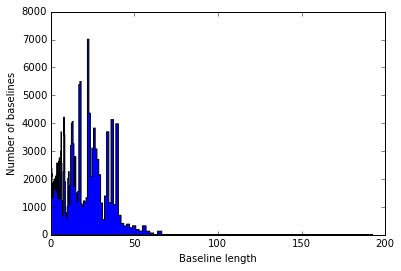

Percentage outputs per bin:  [ 0.04861136  0.0382457   0.04682418  0.05611753  0.06433856  0.06541087
  0.09150374  0.0911463   0.10830325  0.13046431  0.11509454  0.12224327
  0.14225971  0.14261715  0.13260893  0.16656539  0.18336491  0.16013154
  0.19623262  0.18086285  0.20767059  0.23698038  0.21231726  0.24412911
  0.26879222  0.28988097  0.30918254  0.37995496  0.3842442   0.36708725
  0.40926475  0.45179969  0.42106016  0.48075205  0.49254745  0.52972084
  0.56331987  0.59227222  0.63159023  0.65267899  0.65339386  0.67055081
  0.6773421   0.7459699   0.75097401  0.80816385  0.75204632  0.76419916
  0.74132323  0.76991815  0.80780641  0.85606034  0.78421561  0.76884584
  0.77992637  0.74489759  0.76276942  0.66840619  0.60764199  0.58869786
  0.59334453  0.56331987  0.52900597  0.53543983  0.58119169  0.62694356
  0.60942917  0.59155735  0.55080959  0.47682025  0.55795832  0.65339386
  0.65518104  0.64874719  0.56046038  0.50005362  0.57189835  0.67233799
  0.62444151  0.621582

In [5]:
import numpy as np
import math
import os
import sys
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

def readcol(filename,col_number,comment='#'):
        """
        read in a file
        """
        f    = open(filename,'r')
        line = f.readline()

        column = []
        while line:
                columns = line.split()
                column.append(float(columns[col_number-1]))
                line = f.readline()
        f.close()
        return(column)

telescope='LOW' #choose telescope
use_given_bins=False #either use baseline bins matching those currently in the main parametric model or creat new ones..."
binning_type='log' #and if you make new ones, have either 'linear' or 'log' spacing. 


if telescope=='LOW':
    config_reader_file=os.getcwd()+'/Reference_Layouts/LOW_LONG_LAT_ECP.wgs84.753x4.txt'
    baseline_bins = np.array((0, 4.9, 7.1, 10.4, 15.1, 22.1, 32.2, 47.0, 80.0))

elif telescope=='MID':
    config_reader_file=os.getcwd()+'/Reference_Layouts/MID_LONG_LAT_ECP.wgs84.254x4.txt'
    baseline_bins = np.array((0, 4.4, 6.7, 10.3, 15.7, 24.0, 36.7, 56.0, 85.6, 130.8, 150))

dish_longitude=readcol(config_reader_file, 2)
dish_latitude=readcol(config_reader_file, 3)
dish_diameter=readcol(config_reader_file, 1)
Rearth=6371010.0/1000.0
Number_positions=int(len(dish_diameter)-1)
print "Number of positions in file", Number_positions

array_long_centre=dish_longitude[Number_positions]
array_lat_centre=dish_latitude[Number_positions]
array_centre_diameter=dish_diameter[Number_positions]

print "array_long_centre", array_long_centre
print "array_lat_centre", array_lat_centre
if array_centre_diameter!=0.0: print "array_centre_diameter", array_centre_diameter, '(should be zero, just a check)'

degtorad=2.0*math.pi/360.0

#get x,y,z cartesian coordinates for positions (assuming they sit on a sphere of radius Rearth)
array_x_centre=Rearth*math.cos(array_lat_centre*degtorad)*math.cos(array_long_centre*degtorad)
array_y_centre=Rearth*math.cos(array_lat_centre*degtorad)*math.sin(array_long_centre*degtorad)
array_z_centre=Rearth*math.sin(array_lat_centre*degtorad)
print "Filename used for configuration: ", os.path.basename(config_reader_file)
print "Number of positions in file", Number_positions
Array_dx=[]
Array_dy=[]
Array_dz=[]
Array_r=[]
for i in range(Number_positions):
	Array_dx.append(Rearth*math.cos(dish_latitude[i]*degtorad)*math.cos(dish_longitude[i]*degtorad)-array_x_centre)
	Array_dy.append(Rearth*math.cos(dish_latitude[i]*degtorad)*math.sin(dish_longitude[i]*degtorad)-array_y_centre)
	Array_dz.append(Rearth*math.sin(dish_latitude[i]*degtorad)-array_z_centre)
	Array_r.append(math.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))
        
"""
Absolute lengths of each baseline are calculated for every possible pairing in the array.
This is very conservative and gives the worst possible case for input baseline lengths going into the performance model.
But, it is trivial to calculate! File arrangements are as generated by iantconfig (by the very talented Matteiu De Villiers).
see http://public.ska.ac.za/software/iantconfig
"""
Baseline_lengths=[]
for i in range(Number_positions):
        for j in range(Number_positions):
                if j > i:
                    blength=(math.sqrt((Array_dx[j]-Array_dx[i])**2 + (Array_dy[j]-Array_dy[i])**2 + (Array_dz[j]-Array_dz[i])**2))
                    Baseline_lengths.append(blength)
                    
                    
#print Baseline_lengths
print "Baselines: ", len(Baseline_lengths)
#print Baseline_lengths[0:1000]

#
# create a histogram by providing the bin edges (unequally spaced)
#

if use_given_bins:
    bins=baseline_bins
else:
 nbins=200
 bmax=200
 bmin=0.1
 bin_number=range(nbins)
 bins=bin_number
 for i in range(nbins):
        if binning_type=="log":
            cutoff=bmin*10**(log10(bmax/bmin)*float(i)/float(nbins))
        elif binning_type=="linear":
            cutoff=bmin+float(i)*(bmax-bmin)/nbins
        else: print "Binning type is not defined"
        bins[i]=(cutoff)

print "Bins used: ", len(bins)
n, bins, patches = hist(Baseline_lengths, bins, normed=False, histtype='stepfilled')
plt.ylabel('Number of baselines')
plt.xlabel('Baseline length')
plt.show()
#print n
#print sum(n)
print "Percentage outputs per bin: ",100.0*n/sum(n)
print "Bin top edge: ", bins[1:]


